850-hPa Geopotential Heights, Temperature, and Winds
====================================================

Classic 850-hPa with Geopotential Heights, Temperature, and Winds

This example uses example data from the GFS analysis for 12 UTC 26
October 2010 and uses xarray as the main read source with using MetPy to
calculate frontogenesis and wind speed with geographic plotting using
Cartopy for a CONUS view.


In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
import numpy as np
import xarray as xr

Use Xarray to read netCDF data from a remote server and use MetPy’s
parse_cf() capability to make it easy to get arrays with attached units.


In [2]:
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/casestudies/'
                     'python-gallery/GFS_20101026_1200.nc').metpy.parse_cf()

Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Proje

Subset Data
-----------

Bring in individual variables and subset for domain that is being
analyzed (roughly CONUS). There are a couple of MetPy helpers being used
here to get arrays with units (``.metpy.unit_array``) and selecting on a
generic “vertical” domain.


In [3]:
# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(200, 350)
lat_slice = slice(85, 10)

# Grab lat/lon values (GFS will be 1D)
lats = ds.lat.sel(lat=lat_slice).values
lons = ds.lon.sel(lon=lon_slice).values

# Set level to plot/analyze
level = 850 * units.hPa

# Grad individual data arrays with units from our file, selecting for level and lat/lon slice
hght_850 = ds.Geopotential_height_isobaric.metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array
tmpk_850 = ds.Temperature_isobaric.metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array
uwnd_850 = ds['u-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array
vwnd_850 = ds['v-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array

# Convert temperatures to degree Celsius for plotting purposes
tmpc_850 = tmpk_850.to('degC')

# Get a sensible datetime format
vtime = ds.time.data[0].astype('datetime64[ms]').astype('O')

Figure Creation
---------------

Here we use Cartopy to plot a CONUS map using a Lambert Conformal
projection - note: the data is in a lat/lon projection, so the
PlateCarree projection is used as the data projection.


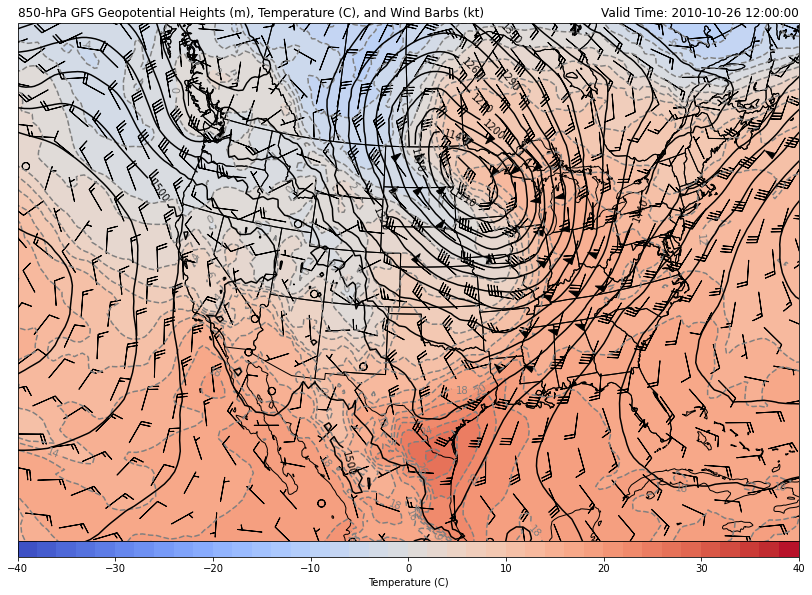

In [4]:
# Set output projection
mapcrs = ccrs.LambertConformal(
    central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))

# Set projection of data (so we can transform for the figure)
datacrs = ccrs.PlateCarree()

# Start figure and set extent to be over CONUS
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add coastline and state map features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot colorfill and dashed contours of 850-hPa temperatures in Celsius
clevs_850_tmpc = np.arange(-40, 41, 2)
cf = ax.contourf(lons, lats, tmpc_850, clevs_850_tmpc, cmap=plt.cm.coolwarm, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label('Temperature (C)')
csf = ax.contour(lons, lats, tmpc_850, clevs_850_tmpc, colors='grey',
                 linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')

# Plot contours of 850-hPa geopotential heights in meters
clevs_850_hght = np.arange(0, 8000, 30)
cs = ax.contour(lons, lats, hght_850, clevs_850_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot wind barbs every fifth element
wind_slice = (slice(None, None, 5), slice(None, None, 5))
ax.barbs(lons[wind_slice[0]], lats[wind_slice[1]],
         uwnd_850[wind_slice[0], wind_slice[1]].to('kt').m,
         vwnd_850[wind_slice[0], wind_slice[1]].to('kt').m,
         pivot='middle', color='black', transform=datacrs)

# Add some titles
plt.title('850-hPa GFS Geopotential Heights (m), Temperature (C), '
          'and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right');